In [2]:
%load_ext autoreload
import os
os.chdir(os.path.abspath(os.curdir).replace('notebooks',''))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import datetime
from tqdm import trange
import pandas as pd
pd.set_option('display.max_colwidth', 120)

In [4]:
%autoreload 2

from src.database import ElasticTransformers

In [5]:
from sentence_transformers import SentenceTransformer

bert_embedder = SentenceTransformer('bert-base-nli-mean-tokens')

In [6]:
def embed_wrapper(ls):
    """
    Helper function which simplifies the embedding call and helps lading data into elastic easier
    """
    results=bert_embedder.encode(ls, convert_to_tensor=True)
    results = [r.tolist() for r in results]
    return results


In [7]:
et=ElasticTransformers(index_name='et-test')
et.ping()

True

# Search Experiments

To analyse results, I compared top results side by side on a few searches. 

Approach is to take the top 10 hits, after removing some of the noisy results (duplicates or “headlines” of just one word).


In [166]:
def select_search_results(df,top_n=10):
    # four tokens or more (filtering out some meaningless headlines)
    df=df[df.headline_text.apply(lambda x: len(x.split())>4)].copy()
    # remove exact duplicates
    df=df.groupby('headline_text', as_index=False).first()
    df=df.sort_values('_score',ascending=False)
    df=df.reset_index(drop=True)
    return df.head(top_n)

In [191]:
query='virus threat'
print('KEYWORD SEARCH RESULTS')
df0=et.search(query,'headline_text',type='match',embedder=embed_wrapper, size = 1000)
display(select_search_results(df0))
print('SEMANTIC SEARCH RESULTS')
df1=et.search(query,'headline_text',type='dense',embedder=embed_wrapper, size = 1000)
display(select_search_results(df1))



KEYWORD SEARCH RESULTS


,headline_text,_score
0,cattle producers warned of virus threat,13.377153
1,public warned of mozzie virus threat,13.377153
2,residents reminded of mozzie virus threat,13.270668
3,mozzie virus threat sparks health alert,13.181980
4,report reveals lower mozzie virus threat,13.181980
5,expert plays down hendra virus threat,13.181980
6,hendra virus poses constant threat chief vet,12.560108
7,public warned of mossie borne virus threat,12.560108
8,public warned to avoid mossie virus threat,12.560108
9,sunraysia fears watermelon virus threat from nt,12.460496


SEMANTIC SEARCH RESULTS


,headline_text,_score
0,hendra like virus identified as potential threat,1.859409
1,hendra report author warns of virus risk,1.853365
2,fresh concerns over hendra virus outbreak,1.836927
3,virus puts giteau in doubt,1.823136
4,hendra virus case under investigation,1.817768
5,who highlight dangers of vector borne diseases,1.804388
6,potentially deadly virus sparks mozzie warning,1.799419
7,who warns threat from vector borne diseases,1.793783
8,fears as png diseases spread,1.791913
9,deadly hendra virus strikes again,1.788590


In [189]:
#query='virus threat'
query='regulatory risk banking reform'
print('KEYWORD SEARCH RESULTS')
df0=et.search(query,'headline_text',type='match',embedder=embed_wrapper, size = 1000)
display(select_search_results(df0))
print('SEMANTIC SEARCH RESULTS')
df1=et.search(query,'headline_text',type='dense',embedder=embed_wrapper, size = 1000)
display(select_search_results(df1))



KEYWORD SEARCH RESULTS


,headline_text,_score
0,regulatory madness in the banking world,18.773428
1,swan to announce banking reform package,14.681509
2,china pushes through banking sector reform,14.628473
3,open banking more choice or data risk,12.978978
4,swan wraps up meeting on banking rules reform,12.897368
5,regulatory duplication strangling aquaculture development,11.631692
6,us flags financial regulatory reforms,11.631692
7,mcconnell a regulatory train wreck,11.631692
8,govt internet regulatory plan criticised,11.630816
9,thailand reverses regulatory controls after stocks,10.875205


SEMANTIC SEARCH RESULTS


,headline_text,_score
0,us flags financial regulatory reforms,1.863391
1,the banking royal commissions recommendations,1.850401
2,what can we expect from the banking inquiry,1.841991
3,banking royal commission superannuation hearings,1.836119
4,banking royal commission anz financial advice clients interest,1.833776
5,rba considers cap on credit card surcharges,1.832314
6,rba on banks interest rate moves,1.831732
7,will changes to financial advice laws see the,1.831395
8,commonwealth bank responds to financial planning inquiry,1.831379
9,reserve bank financial stability review,1.830978


# Speed comparison

Below we perform some non-functional testing on the impact of size of index together with search parameters on time of the query.  
We have tested with 3 index sizes: 1k (Tiny), 100k (Medium) & 1.1mn (Large). We have not paid particular attention to and sampling effects, meaning that for instance, the 1k index is simply the first 1000 headlines in the data, this might mean ti is not well randomized, which we have not studied

In [93]:

queries=['Amazon','news','security thread','tech news','new vaccine developed new cure','results game today all winners']
result_sizes=[1,10,100]
repeat=10

col_names=['search index','search type','search size' , 'query', '# tokens query','repeat','time taken']
search_to_compare={'dense':'Semantic Search','match':'Keyword Search'}
indices_to_compare={'et-tiny':'Tiny','et-medium':'Medium','et-test':'Large'}

res=[]
for i in trange(repeat):
    for index in indices_to_compare:
        for search_type in search_to_compare:
            for query in queries:
                for size in result_sizes:
                    t0=datetime.datetime.now()
                    _ = et.search(query=query,
                                  field='headline_text',
                                  index_name=index,
                                  type=search_type,
                                  embedder=embed_wrapper, 
                                  size=size)
                    t1=datetime.datetime.now()
                    time_taken=(t1-t0).total_seconds()
                    res.append([indices_to_compare[index], search_labels[search_type], size, query, len(query.split()), i,time_taken])
                    
result_df=pd.DataFrame(res, columns=col_names)
result_df.to_csv('data/results_search.csv')


100%|██████████| 10/10 [23:28<00:00, 140.86s/it]


Compare speed across different index sizes and search types for
- query token length
- result size
- index size

Results are below

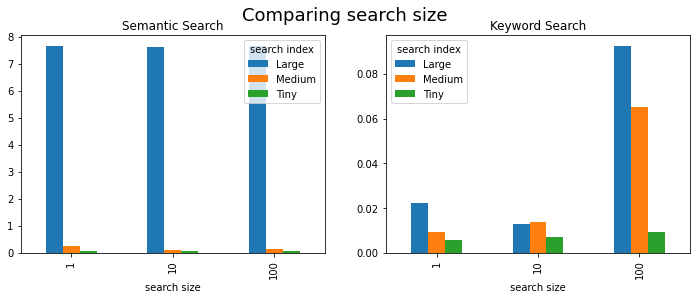

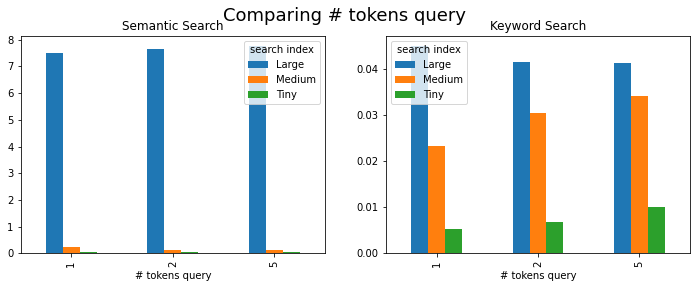

In [124]:
compare='search size' #'# tokens query'
compare='# tokens query'
comparisons=['search size', '# tokens query']

for compare in comparisons:
    fig, axes = plt.subplots(nrows=1, ncols=len(search_labels), figsize=(12,4))
    fig.suptitle(f'Comparing {compare}',size=18)
    for (c,search_type) in enumerate(search_labels.values()):
        pvt=pd.pivot_table(result_df[(result_df['search type']==search_type)&(result_df['repeat']>2)] \
                           [['search index',compare,'time taken']],\
                    values='time taken',
                    index=compare,
                    columns='search index',
                    aggfunc='mean',
                  )
        pvt.plot.bar(title=search_type,ax=axes[c]) 


The below box plot analyzes the deviation in search times after multiple repeated calls. Although some deviations are observed, they do not seem to be significant. Only results from the Large index are shown

<AxesSubplot:>

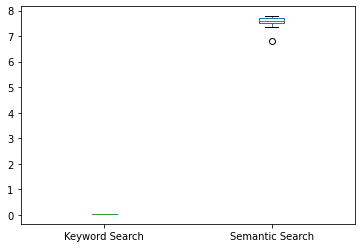

In [190]:
box_df=result_df[(result_df['search index']=='Large')].copy()
pd.pivot_table(box_df[['search type','time taken','repeat']][4:],
               values='time taken',
                    index='repeat',
                    columns='search type',
                    aggfunc='mean',).plot.box()